In [83]:
#classification에 필요한 라이브러리 불러오기
import torch
import torch.nn as nn
from torch.autograd import Variable
#torch.autograd 라이브러리 내에 있는 Variable 함수를 사용하겠다는 의미

import numpy as np
import pandas as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [85]:
#torchvision을 이용해 MNIST Fashion 데이터를 불러오기
train_set = torchvision.datasets.FashionMNIST("./data",
                                              download=True,
                                              transform = transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data",
                                            download=True, train=False,
                                            transform = transforms.Compose([transforms.ToTensor()]))

In [86]:
#train_loader, test_loader 불러오기
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 100)

In [87]:
#데이터셋에 대한 라벨링
def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Snearker",
        8: "Bag",
        9: "Ankle Boot"        
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [88]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [89]:
len(train_set)

60000

In [90]:
len(test_set)

10000

9


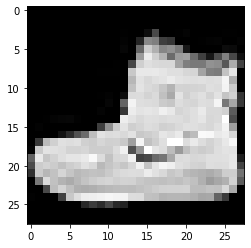

In [91]:
#데이터셋이 어떤 데이터셋을 가지고 있는지 시각화
#matplotlib.pyplot을 시각화에 이용함
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap='gray')
print(label)

In [92]:
#CNN 모델을 구성하기
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        #전 연결
        self.fc1=nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0, 25)
        self.fc2 = nn.Linear(in_features = 600, out_features=120)
        self.fc3 = nn.Linear(in_features = 120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [93]:
#모델 구조 파악하기 / 사실 잘 사용하지는 않음
# torchsummary를 더 잘 사용함
model = CNN()
model.to(device) #GPU 연산이 가능하도록 .to(advice)

error = nn.CrossEntropyLoss()

learning_rate= 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0, inplace=25)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [94]:
#training

num_epochs = 15
count = 0

#실행에 필요한 loss, iteration, accuracy 시각화를 하기 위해 list 형태로 초기화
loss_list=[]
iteration_list =[]
accuracy_list =[]

#list 형태로 초기화를 하는 과정
predictions_list =[]
labels_list =[]

#epoch만큼 반복훈련이 실행됨
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = error(outputs, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        count +=1
        
        if not (count %50):
            total = 0
            correct = 0
            
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                
                outputs = model(test)
                
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
            if not (count % 500):
                print("iteration:{}, Loss:{}, Accuracy: {}%".format(count, loss.data, accuracy))

iteration:500, Loss:2.30466365814209, Accuracy: 12.059999465942383%
iteration:1000, Loss:2.3125510215759277, Accuracy: 12.059999465942383%
iteration:1500, Loss:2.2640280723571777, Accuracy: 12.059999465942383%
iteration:2000, Loss:2.2752857208251953, Accuracy: 12.059999465942383%
iteration:2500, Loss:2.2985618114471436, Accuracy: 12.059999465942383%
iteration:3000, Loss:2.269038438796997, Accuracy: 12.059999465942383%
iteration:3500, Loss:2.30466365814209, Accuracy: 12.059999465942383%
iteration:4000, Loss:2.3125510215759277, Accuracy: 12.059999465942383%
iteration:4500, Loss:2.2640280723571777, Accuracy: 12.059999465942383%
iteration:5000, Loss:2.2752857208251953, Accuracy: 12.059999465942383%
iteration:5500, Loss:2.2985618114471436, Accuracy: 12.059999465942383%
iteration:6000, Loss:2.269038438796997, Accuracy: 12.059999465942383%
iteration:6500, Loss:2.30466365814209, Accuracy: 12.059999465942383%
iteration:7000, Loss:2.3125510215759277, Accuracy: 12.059999465942383%
iteration:7500,

In [ ]:
#+matplotlib을 이용한 시각화

#plt.plot(iteration_list, loss_list)
#plt.xlabel("Number of iteration")
#plt.ylabel("Loss")
#plt.title("iteration vs Loss")
#plt.show()

In [103]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs,1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), 
                                           class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 7.60%
Accuracy of Trouser: 5.10%
Accuracy of Pullover: 23.00%
Accuracy of Dress: 0.30%
Accuracy of Coat: 2.10%
Accuracy of Sandal: 0.00%
Accuracy of Shirt: 12.40%
Accuracy of Snearker: 0.00%
Accuracy of Bag: 26.80%
Accuracy of Ankle Boot: 43.30%
